
# Step 4 — Explore the Latent Space and Evaluate
This notebook discovers **new product vectors** by sampling your **latent space** (`X_latent.csv`), predicting product qualities with a tiny **k‑NN surrogate**, and selecting promising candidates by a scalar fitness and **novelty**.  
It uses only `numpy`, `pandas`, and `matplotlib`.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Do not rely on seaborn; keep one chart per figure and default colors.


In [11]:

# ---------- Helper functions ----------

def find_col(df, names):
    # Return the first column whose lowercase name contains any of the substrings in `names`.
    ln = [n.lower() for n in names]
    for c in df.columns:
        lc = c.strip().lower()
        if any(s in lc for s in ln):
            return c
    return None

def health_to_unit(h_ser):

    # Map health score 1..5 (A..E) -> health_unit 1..0 (higher is healthier).
    s = pd.to_numeric(h_ser, errors="coerce")
    return (5 - s.clip(1,5).round()) / 4.0

def knn_predict(X_train, y_train, X_query, k=15, eps=1e-8):

    #Lightweight k-NN regression with inverse-distance weights (no sklearn).
    nq = X_query.shape[0]
    y_pred = np.empty(nq, dtype=float)
    for i in range(nq):
        diff = X_train - X_query[i]
        d2 = np.einsum("ij,ij->i", diff, diff)
        k_eff = min(k, len(d2))
        idx = np.argpartition(d2, k_eff-1)[:k_eff]
        d = np.sqrt(d2[idx]) + eps
        w = 1.0 / d
        w = w / w.sum()
        y_pred[i] = float(np.dot(w, y_train[idx]))
    return y_pred

def predict_bundle(X_train, taste, price, health_unit, X_query, k=15):
    t_hat = knn_predict(X_train, taste,       X_query, k=k)
    p_hat = knn_predict(X_train, price,       X_query, k=k)
    h_hat = knn_predict(X_train, health_unit, X_query, k=k)
    fit = t_hat + (1 - p_hat) + h_hat  # weights can be adjusted if needed
    return t_hat, p_hat, h_hat, fit

def min_dist_to_train(X_train, Xq):
    #Nearest Euclidean distance in latent Z to the training set, per query row.
    md = np.empty(Xq.shape[0], dtype=float)
    for i in range(Xq.shape[0]):
        diff = X_train - Xq[i]
        d2 = np.einsum("ij,ij->i", diff, diff)
        md[i] = float(np.sqrt(d2.min()))
    return md



## Parameters
Adjust these to control sampling and selection.


In [3]:

# Paths 
BASE = Path(".")  
PATH_LATENT = BASE / "../data/mlready/X_latent.csv"
PATH_CORE   = BASE / "../data/mlready/step12-vector-core.csv"

# Exploration settings
RANDOM_SEED        = 7
NUM_SAMPLES        = 1000      # how many new Z points to sample
K_NEIGHBORS        = 15        # k for k-NN surrogate
NOVELTY_KEEP_PCT   = 60.0      # keep upper (100 - pct) % by novelty; 60 -> keep most novel 40%
TOP_N              = 20        # how many candidates to keep

# Fitness weights
WT, WC, WH = 1.0, 1.0, 1.0     # fitness = WT * taste + WC * (1 - price) + WH * health_unit



## Load latent vectors and core product qualities
`X_latent.csv` should have one row per product and columns `z1..zD`.  
`step12-vector-core.csv` should include `taste_balance`, `price_norm`, and `health_score`.


In [4]:

Z = pd.read_csv(PATH_LATENT)
core = pd.read_csv(PATH_CORE)

# Align lengths if they differ
nZ = len(Z); nC = len(core)
if nZ != nC:
    m = min(nZ, nC)
    Z = Z.iloc[:m].reset_index(drop=True)
    core = core.iloc[:m].reset_index(drop=True)

print("Latent shape:", Z.shape)
print("Core shape:", core.shape)
Z.head()


Latent shape: (92457, 8)
Core shape: (92457, 4)


,z1,z2,z3,z4,z5,z6,z7,z8
0,-13.019607,-7.894012,1.281802,6.181080,-10.102024,-12.751914,5.709426,12.557178
1,-4.850225,-7.840496,3.704070,-3.589121,-5.760457,1.964373,-3.984722,-2.106689
2,7.472287,-3.434261,2.268410,-17.253546,1.956961,19.563770,-13.674089,-17.460411
3,9.944679,-4.199348,3.728224,-14.041764,-1.841047,18.360111,-13.311253,-13.752280
4,-0.936796,-9.269890,5.304223,-2.345257,-8.079560,1.650454,-3.001152,1.076610



## Prepare targets and training arrays for the surrogate


In [5]:

taste_col  = find_col(core, ["taste_balance","taste"])
price_col  = find_col(core, ["price_norm","price"])
health_col = find_col(core, ["health_score","health"])

assert taste_col and price_col and health_col, f"Missing required columns. Found: {core.columns.tolist()}"

taste = pd.to_numeric(core[taste_col], errors="coerce").to_numpy(dtype=float)
price = pd.to_numeric(core[price_col], errors="coerce").to_numpy(dtype=float)
health_unit = health_to_unit(core[health_col]).to_numpy(dtype=float)

X = pd.DataFrame(Z).to_numpy(dtype=float)

print("Columns used ->", dict(taste=taste_col, price=price_col, health=health_col))


Columns used -> {'taste': 'taste_balance', 'price': 'price_norm', 'health': 'health_score'}



## Visualize the latent space (PCA 2D)


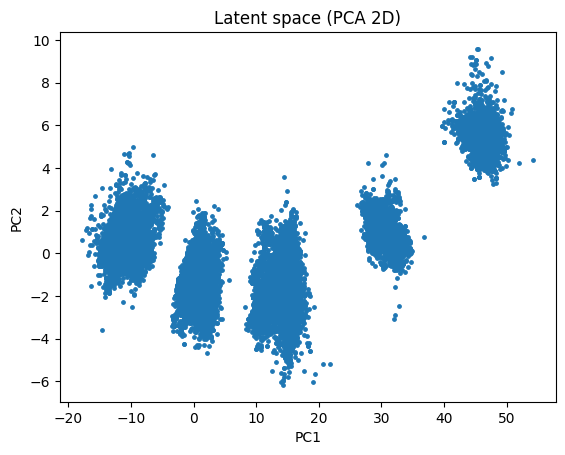

In [6]:

# Center and SVD for PCA
Xc = X - X.mean(axis=0)
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
pc = U[:, :2] @ np.diag(S[:2])

plt.figure()
plt.scatter(pc[:,0], pc[:,1], s=6)
plt.title("Latent space (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



## Sample new latent points and predict product qualities
We sample from a normal distribution using the empirical mean and std of your latent vectors.


In [7]:

rng = np.random.default_rng(RANDOM_SEED)
mu = X.mean(axis=0)
sd = X.std(axis=0)
sd[sd == 0] = 1.0

Z_new = rng.normal(loc=mu, scale=sd, size=(NUM_SAMPLES, X.shape[1]))

# Predict with k-NN surrogate
t_hat = knn_predict(X, taste,       Z_new, k=K_NEIGHBORS)
p_hat = knn_predict(X, price,       Z_new, k=K_NEIGHBORS)
h_hat = knn_predict(X, health_unit, Z_new, k=K_NEIGHBORS)

fitness_hat = WT * t_hat + WC * (1 - p_hat) + WH * h_hat

# Novelty: nearest distance in Z to any training point
novelty_Z = min_dist_to_train(X, Z_new)

df_new = pd.DataFrame(Z_new, columns=[f"z{i+1}" for i in range(Z_new.shape[1])])
df_new["taste_hat"] = t_hat
df_new["price_hat"] = p_hat
df_new["health_unit_hat"] = h_hat
df_new["fitness_hat"] = fitness_hat
df_new["novelty_Z"] = novelty_Z

# Keep reasonable predictions
mask = df_new["taste_hat"].between(0,1) & df_new["price_hat"].between(0,1) & df_new["health_unit_hat"].between(0,1)
df_new = df_new[mask].reset_index(drop=True)

print("Candidates after filtering:", len(df_new))
df_new.head()


Candidates after filtering: 1000


,z1,z2,z3,z4,z5,z6,z7,z8,taste_hat,price_hat,health_unit_hat,fitness_hat,novelty_Z
0,-8.530245,-7.714529,1.953806,-2.427961,-10.352934,-13.977301,1.424608,17.108421,0.339919,0.129514,0.000000,1.210405,9.714631
1,-11.132246,-9.036891,3.088665,4.315477,-9.168102,-13.481778,0.940605,12.766858,0.541109,0.274827,0.000000,1.266282,3.829625
2,-15.625071,-8.802607,-0.463159,-4.584524,-13.287200,-7.849490,-5.763208,9.912219,0.522827,0.489602,0.250000,1.283225,11.194364
3,-7.710149,-8.413208,-1.377513,-0.525717,-9.493702,-5.027582,-7.185456,4.869815,0.690303,0.904634,0.250000,1.035669,7.388997
4,-13.696679,-9.307863,3.936945,-1.978983,-9.459899,1.217879,-2.060740,7.334081,0.282579,0.677313,0.283428,0.888695,7.306301



## Select top candidates (fitness + novelty)
We keep the most novel 40% by default, then sort by fitness (desc), novelty (desc), and price (asc).


In [8]:

# Novelty filter
thr = float(np.nanpercentile(df_new["novelty_Z"], NOVELTY_KEEP_PCT)) if len(df_new) else np.nan
df_sel = df_new[df_new["novelty_Z"] >= thr].copy()

# Rank and pick top N
df_sel = df_sel.sort_values(["fitness_hat","novelty_Z","price_hat"], ascending=[False, False, True])
topN = df_sel.head(TOP_N).reset_index(drop=True)

print("Novelty threshold:", thr)
print("Top candidates:", len(topN))
topN[["fitness_hat","taste_hat","price_hat","health_unit_hat","novelty_Z"]].head(10)


Novelty threshold: 10.15627681073386
Top candidates: 20


,fitness_hat,taste_hat,price_hat,health_unit_hat,novelty_Z
0,2.042442,0.632869,0.073563,0.483135,16.322392
1,2.022021,0.649687,0.127666,0.500000,10.448167
2,2.004956,0.798315,0.043358,0.250000,11.567520
3,1.997473,0.648105,0.150632,0.500000,10.664702
4,1.937457,0.732142,0.044684,0.250000,14.522576
5,1.926167,0.752707,0.076540,0.250000,11.817791
6,1.905087,0.782501,0.127414,0.250000,16.674704
7,1.895055,0.622271,0.227216,0.500000,18.299258
8,1.871393,0.661010,0.039617,0.250000,16.143493
9,1.870651,0.623069,0.002418,0.250000,10.358521



## Save results


In [9]:

OUT_CSV = Path("latent_top_candidates.csv")
topN.to_csv(OUT_CSV, index=False)
print("Saved ->", OUT_CSV.resolve())


Saved -> C:\Users\Administrateur\Desktop\Narvik-university-AI-courses\Assignment 1\4-explore-latent-space\latent_top_candidates.csv



## Plots
Separate figures (no subplots, default colors):
- Fitness distribution of sampled candidates
- Novelty vs Fitness scatter (selected set)
- PCA again with only the **top** candidates (for a quick look)


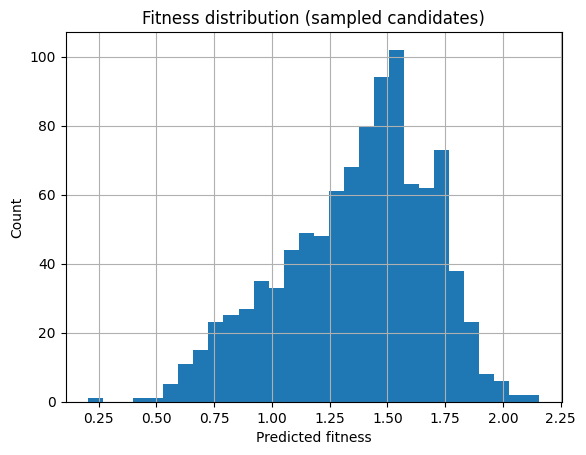

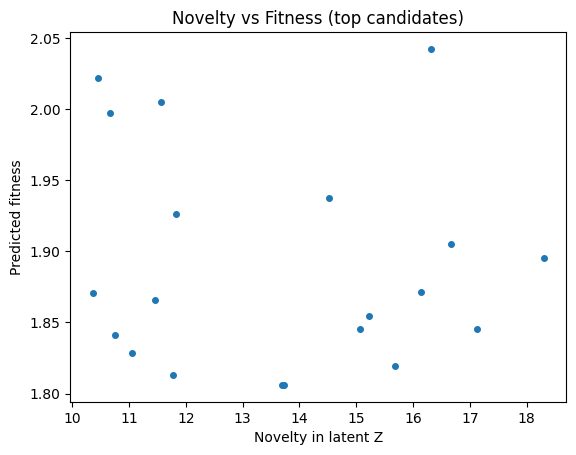

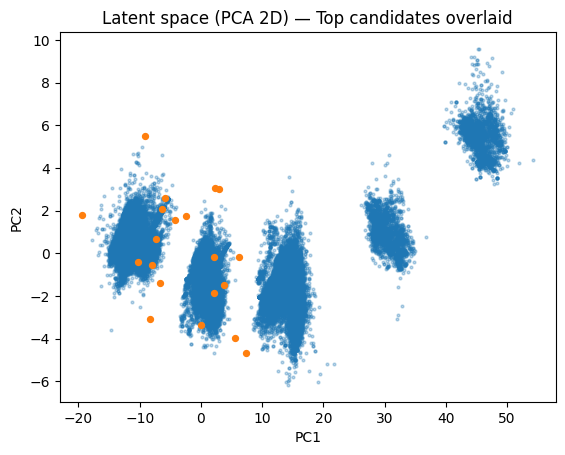

In [10]:

# Fitness distribution
plt.figure()
df_new["fitness_hat"].hist(bins=30)
plt.title("Fitness distribution (sampled candidates)")
plt.xlabel("Predicted fitness")
plt.ylabel("Count")
plt.show()

# Novelty vs Fitness
plt.figure()
plt.scatter(topN["novelty_Z"], topN["fitness_hat"], s=16)
plt.title("Novelty vs Fitness (top candidates)")
plt.xlabel("Novelty in latent Z")
plt.ylabel("Predicted fitness")
plt.show()

# PCA with top candidates (project new Z to first two PCs)
Z_new_c = Z_new - X.mean(axis=0)
pc_new = Z_new_c @ Vt[:2].T

plt.figure()
plt.scatter(pc[:,0], pc[:,1], s=4, alpha=0.3)
plt.scatter(pc_new[:len(topN),0], pc_new[:len(topN),1], s=18)
plt.title("Latent space (PCA 2D) — Top candidates overlaid")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
